**https://github.com/DavidReveloLuna/Semantic-Segmentation-Basic-U-Net**


**https://www.youtube.com/watch?v=3v7sYqigeSc&list=PLsjK_a5MFguLIBZQqxDvgUTp2SegKmMFH&index=19**


## Importing libraries

In [2]:
import os
import numpy as np
import cv2
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

import matplotlib.pyplot as plt

import datetime

from scipy import ndimage
from scipy.ndimage import distance_transform_edt

from sklearn.metrics import jaccard_score
from keras import backend as K

#Libraries to build Unet architecture
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model


Using TensorFlow backend.


## Directories

In [4]:
data_path_train = 'train'
data_path_validation = 'validation'

data_path_test = 'test'


lst_train_img = os.listdir(data_path_train + '/images/')
lst_train_lbl = os.listdir(data_path_train + '/labels/')

lst_val_img = os.listdir(data_path_validation + '/images/')
lst_val_lbl = os.listdir(data_path_validation + '/labels/')

lst_test_img = os.listdir(data_path_test)





## Declaration of constant values

In [6]:
width_shape, height_shape = 128, 128 
batch_size = 16
epochs = 10

## Reading files for training, testing and validation

In [28]:
Xtrain = []
yTrain = []

Xval = []
yval = []

Xtest = []

images_train = [file for file in lst_train_img if file.endswith('png')]
#print("Xtrain: {}".format(images_train))
labels_train = [file for file in lst_train_lbl if file.endswith('png')]
#print("yTrain: {}".format(labels_train))

images_val = [file for file in lst_val_img if file.endswith('png')]
#print("Xval: {}".format(images_val))
labels_val = [file for file in lst_val_lbl if file.endswith('png')]
#print("yval: {}".format(labels_val))

images_test = [file for file in lst_test_img if file.endswith('png')]
#print("Xval: {}".format(images_val))

for file in tqdm(images_train):    
        img = imread(data_path_train +'/images/'+ file)[:,:,:3] 
        img = resize(img,(height_shape,width_shape), mode='constant', preserve_range=True)
        Xtrain.append(img)
        

for file in tqdm(labels_train):        
        lbl = imread(data_path_train +'/labels/'+ file,1)   
        #print(lbl.shape)
        lbl = resize(lbl,(height_shape,width_shape),mode='constant',preserve_range=True)
        lbl = np.expand_dims(lbl,axis=-1)
        yTrain.append(lbl)
        
for file in tqdm(images_val):
    #print(data_path_train +'/images/'+ file)
        img = imread(data_path_validation +'/images/'+ file)[:,:,:3]  
        img = resize(img,(height_shape,width_shape),mode='constant',preserve_range=True)
        Xval.append(img)
        
        
for file in tqdm(labels_val):        
        lbl = imread(data_path_validation +'/labels/'+ file,1)   
        #print(lbl.shape)
        lbl = resize(lbl,(height_shape,width_shape),mode='constant',preserve_range=True)
        lbl = np.expand_dims(lbl,axis=-1)
        #mask = np.maximum(mask,lbl)
        yval.append(lbl)
        

for file in tqdm(images_test):
    #print(data_path_train +'/images/'+ file)
        img = imread(data_path_test+'/'+ file)[:,:,:3]  
        img = resize(img,(height_shape,width_shape),mode='constant',preserve_range=True)
        Xtest.append(img)
        

X_train = np.array(Xtrain,dtype=np.uint8)
#print('X_train:',X_train.shape)
print(X_train.shape)

y_train = np.array(yTrain,dtype=np.float32)
#print('y_train:',y_train.shape)
print(y_train.shape)

X_val = np.array(Xval,dtype=np.uint8)
#print('X_val:',X_val.shape)
print(X_val.shape)

y_val = np.array(yval,dtype=np.float32)
#print('y_val:',y_val.shape)
print(y_val.shape)


X_test = np.array(Xtest,dtype=np.uint8)
#print('X_test:',X_train.shape)
print(X_test.shape)

100%|██████████| 200/200 [00:06<00:00, 28.60it/s]


(610, 128, 128, 3)
(610, 128, 128, 1)
(200, 128, 128, 3)
(200, 128, 128, 1)
(200, 128, 128, 3)


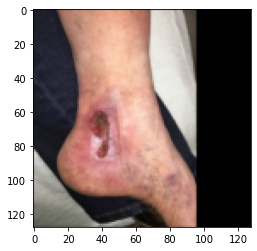

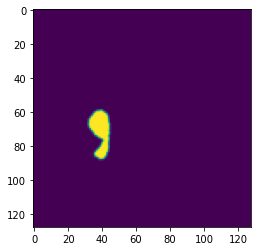

In [8]:
plt.imshow(X_train[305])
plt.show()
plt.imshow(np.squeeze(y_train[305]))
plt.show()

In [9]:
img_input = Input((height_shape,width_shape,3))
img_norm= Lambda(lambda x:x /255)(img_input)

## Unet architecture

In [11]:
conv1 = Conv2D(64,(3,3),activation='relu',padding='same')(Lambda(lambda x:x /255)(img_input))
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
maxp1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(maxp1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
maxp2 = MaxPooling2D((2, 2))(conv2)
 
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(maxp2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
maxp3 = MaxPooling2D((2, 2))(conv3)
 
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(maxp3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
maxp4 = MaxPooling2D(pool_size=(2, 2))(conv4)
 
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(maxp4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

#expansive path
up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
up6 = concatenate([up6, conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)
 
up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
 
up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
 
up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
up9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
 
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
 
model = Model(inputs=[img_input], outputs=[outputs])
#model.compile(optimizer='adam', loss=[jaccard_coef_loss], metrics=[jaccard_coef])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()




Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 1792        lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
'!kill 16758'

In [18]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_val, y_val), 
                    shuffle = False)


Train on 610 samples, validate on 200 samples
Epoch 1/20
610/610 [==============================] - 3s 5ms/sample - loss: 0.0379 - accuracy: 0.9805 - val_loss: 0.0350 - val_accuracy: 0.9818
Epoch 2/20
610/610 [==============================] - 3s 5ms/sample - loss: 0.0365 - accuracy: 0.9811 - val_loss: 0.0355 - val_accuracy: 0.9808
Epoch 3/20
610/610 [==============================] - 3s 5ms/sample - loss: 0.0510 - accuracy: 0.9797 - val_loss: 0.0773 - val_accuracy: 0.9798
Epoch 4/20
610/610 [==============================] - 3s 5ms/sample - loss: 0.0592 - accuracy: 0.9790 - val_loss: 0.0461 - val_accuracy: 0.9798
Epoch 5/20
610/610 [==============================] - 3s 5ms/sample - loss: 0.0451 - accuracy: 0.9791 - val_loss: 0.0434 - val_accuracy: 0.9798
Epoch 6/20
610/610 [==============================] - 3s 5ms/sample - loss: 0.0447 - accuracy: 0.9803 - val_loss: 0.0426 - val_accuracy: 0.9813
Epoch 7/20
610/610 [==============================] - 3s 5ms/sample - loss: 0.0473 - accur

In [19]:
model.save('dfu_unet.hdf5')

## Predictions for training data set (610 images)

In [20]:
predictions_train = model.predict(X_train)
print(predictions_train.shape)

(610, 128, 128, 1)


In [115]:
#for i in range(len(predictions_train)):
#    plt.imshow(np.squeeze(predictions_train[i]))
#    plt.show()
#    plt.imshow(X_train[i])
#    plt.show()

## Predictions for validation data set (200 images)

In [21]:
predictions_val = model.predict(X_val)
print(predictions_val.shape)

(200, 128, 128, 1)


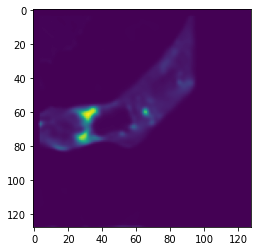

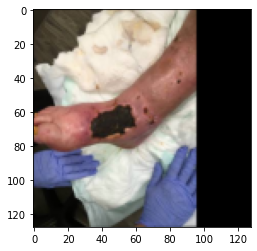

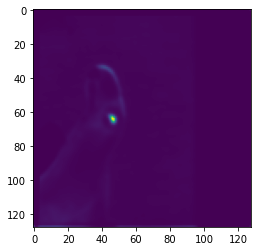

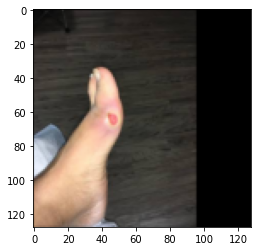

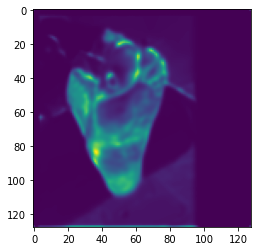

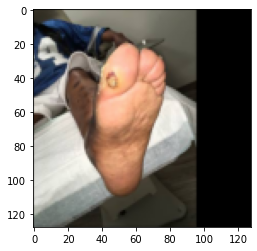

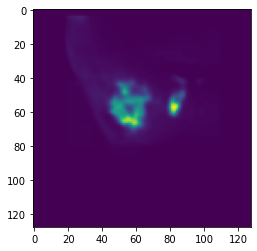

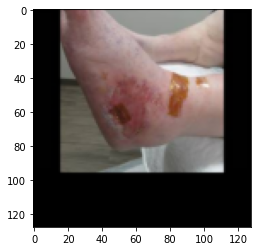

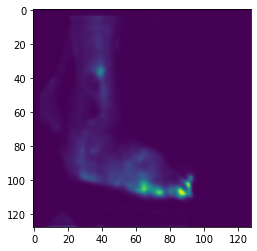

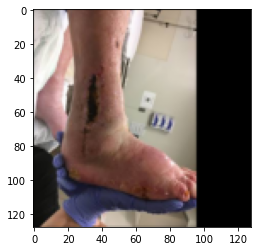

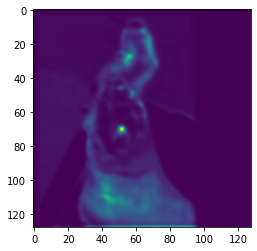

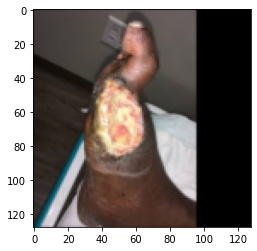

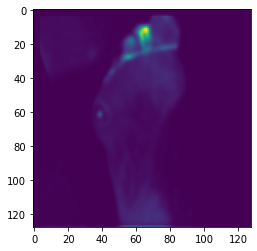

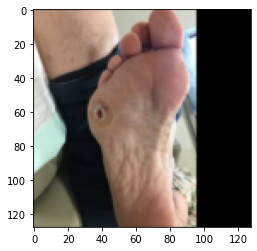

In [23]:
for i in range(7):
    plt.imshow(np.squeeze(predictions_val[i]))
    plt.show()
    plt.imshow(X_val[i])
    plt.show()

## Predictions for testing data set (200 images)

In [29]:
predictions_test = model.predict(X_test)
print(predictions_test.shape)

(200, 128, 128, 1)


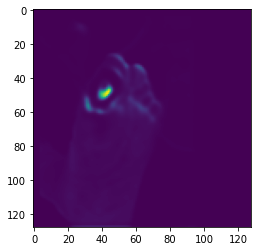

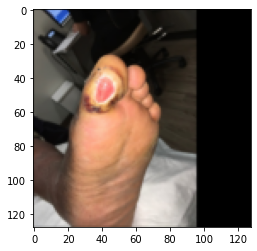

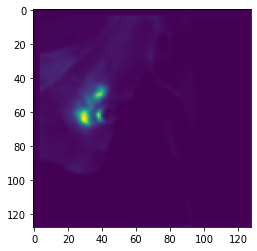

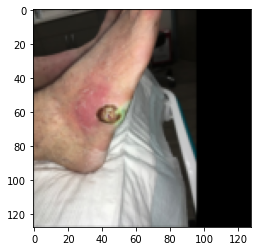

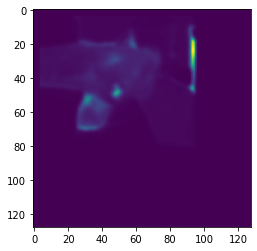

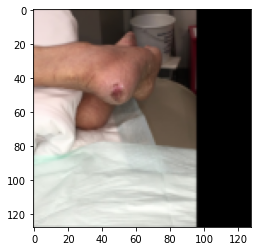

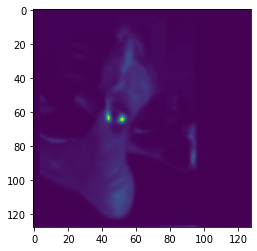

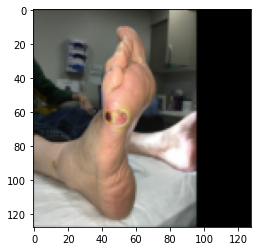

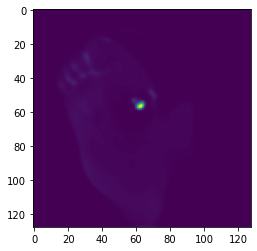

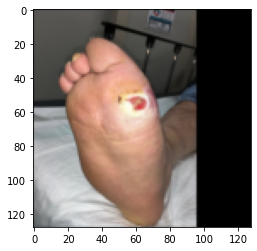

In [30]:
#for i in range(len(predictions_test)):
for i in range(5):
    plt.imshow(np.squeeze(predictions_test[i]))
    plt.show()
    plt.imshow(X_test[i])
    plt.show()

## Pratt's Figure Of Merit (PFOM) definition

In [31]:
DEFAULT_ALPHA = 1.0 / 9

def fom(img, img_gold_std, alpha = DEFAULT_ALPHA):
    """
    Computes Pratt's Figure of Merit for the given image img, using a gold
    standard image as source of the ideal edge pixels.
    """
    edges_img = img
    edges_gold = img_gold_std
    
    # Compute the distance transform for the gold standard image.
    dist = distance_transform_edt(1-edges_gold)

    fom = 1.0 / (np.maximum(np.count_nonzero(edges_img), np.count_nonzero(edges_gold))+0.000000000001)

    N, M = img.shape

    for i in range(0, N):
        for j in range(0, M):
            if edges_img[i, j]:
                fom += 1.0 / ( 1.0 + dist[i, j] * dist[i, j] * alpha)

    fom /= np.maximum(
        np.count_nonzero(edges_img),
        np.count_nonzero(edges_gold))    

    return fom

## Metrics for training data set 

In [32]:
jaccardScore_train=[]
diceScore_train = []
pfom_train = []

for i in range(len(predictions_train)):
    # Converting 3d array to 2d 
    new_pred = predictions_train[i].transpose((2, 0, 1))
    new_pred = predictions_train[i].reshape(predictions_train[i].shape[0], (predictions_train[i].shape[1]*predictions_train[i].shape[2]))
    # Simple binary thresholding
    ret, thresh_pred = cv2.threshold(new_pred, 0, 1, cv2.THRESH_BINARY)
    
    # Converting 3d array to 2d 
    new_test = y_train[i].transpose((2, 0, 1))
    new_test = y_train[i].reshape(y_train[i].shape[0], (y_train[i].shape[1]*y_train[i].shape[2]))
    # Simple binary thresholding
    ret, thresh_test = cv2.threshold(new_test, 0, 1, cv2.THRESH_BINARY)
    
    
    # Jaccard score calculation
    jaccardScore_train.append(jaccard_score(np.int16(thresh_pred),np.int16(thresh_test), average='micro'))
    #print(jaccard_score(np.int16(thresh_pred),np.int16(thresh_test), average='micro'))
    
    #Dice score calculation
    seg = np.int16(thresh_pred)
    gt = thresh_test
    k = 1
    dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))
    diceScore_train.append(dice)
    
    # pratts figure of merit (PFOM) calculation
    edges_seg = seg - ndimage.morphology.binary_erosion(seg)
    edges_gt = gt - ndimage.morphology.binary_erosion(gt)
    pfom_train.append(fom(edges_seg, edges_gt))   
    

## Metrics for validation data set 

In [33]:
jaccardScore_val=[]
diceScore_val = []
pfom_val = []

for i in range(len(predictions_val)):
    # Converting 3d array to 2d 
    new_pred = predictions_val[i].transpose((2, 0, 1))
    new_pred = predictions_val[i].reshape(predictions_val[i].shape[0], (predictions_val[i].shape[1]*predictions_val[i].shape[2]))
    # Simple binary thresholding
    ret, thresh_pred = cv2.threshold(new_pred, 0, 1, cv2.THRESH_BINARY)
    
    # Converting 3d array to 2d 
    new_test = y_val[i].transpose((2, 0, 1))
    new_test = y_val[i].reshape(y_val[i].shape[0], (y_val[i].shape[1]*y_val[i].shape[2]))
    # Simple binary thresholding
    ret, thresh_test = cv2.threshold(new_test, 0, 1, cv2.THRESH_BINARY)
    
    
    # Jaccard score calculation
    jaccardScore_val.append(jaccard_score(np.int16(thresh_pred),np.int16(thresh_test), average='micro'))
    #print(jaccard_score(np.int16(thresh_pred),np.int16(thresh_test), average='micro'))
    
    #Dice score calculation
    seg = np.int16(thresh_pred)
    gt = thresh_test
    k = 1
    dice = np.sum(seg[gt==k])*2.0 / (np.sum(seg) + np.sum(gt))
    diceScore_val.append(dice)
    
    # pratts figure of merit (PFOM) calculation
    edges_seg = seg - ndimage.morphology.binary_erosion(seg)
    edges_gt = gt - ndimage.morphology.binary_erosion(gt)
    pfom_val.append(fom(edges_seg, edges_gt))   
    

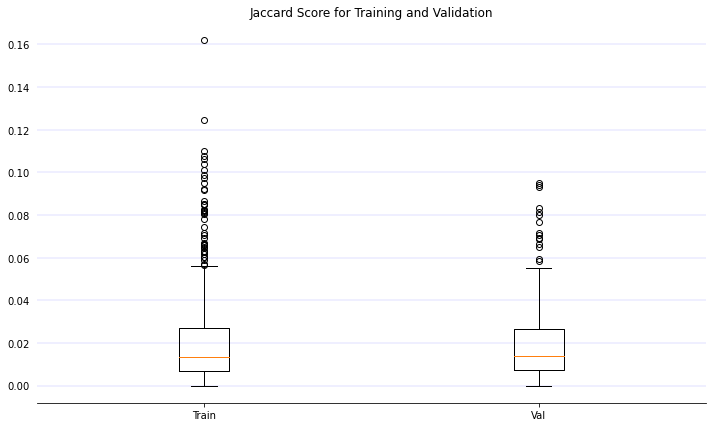

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.grid(color='blue', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Jaccard Score for Training and Validation')
dataset = [jaccardScore_train, jaccardScore_val]
labels = ['Train', 'Val']
ax.boxplot(dataset, labels=labels)
plt.show()

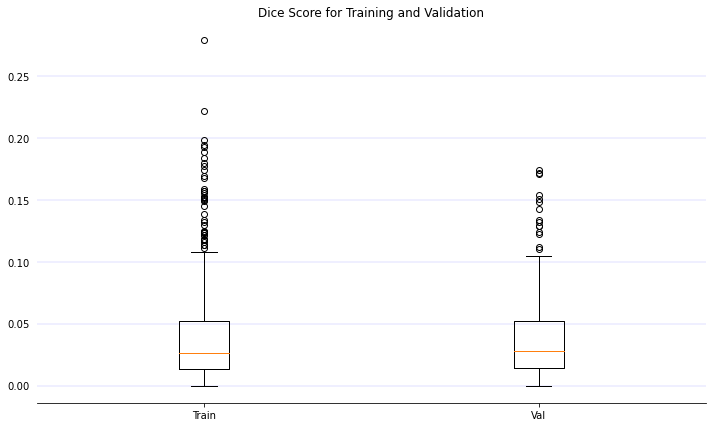

In [35]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.grid(color='blue', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Dice Score for Training and Validation')
dataset = [diceScore_train, diceScore_val]
labels = ['Train', 'Val']
ax.boxplot(dataset, labels=labels)
plt.show()

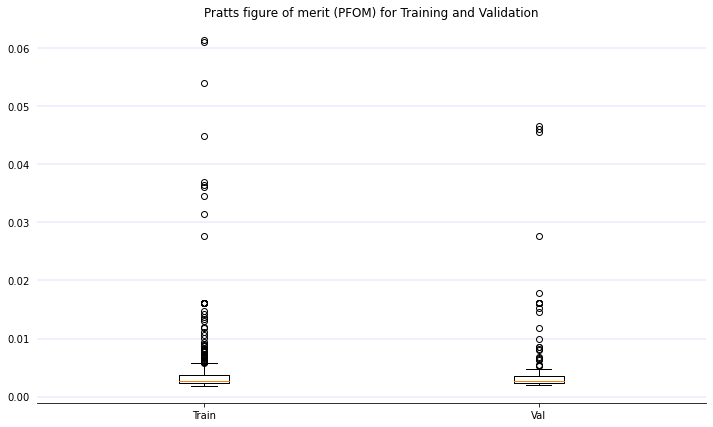

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.grid(color='blue', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Pratts figure of merit (PFOM) for Training and Validation')
dataset = [pfom_train, pfom_val]
labels = ['Train', 'Val']
ax.boxplot(dataset, labels=labels)
plt.show()